In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import datetime

import warnings
warnings.filterwarnings("ignore")

## 데이터 확인
- datetime - hourly date + timestamp  
- season
  - 1 = spring
  - 2 = summer
  - 3 = fall
  - 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather
  - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
  - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
  - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
  - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
---
- **count - number of total rentals**

In [ ]:
data = pd.read_csv('./data/train.csv')
data.head()

In [ ]:
sns.heatmap(data.isnull())
plt.show()
data.info()

## 컬럼 살펴보기
### 1. datetime

In [ ]:
data.datetime

In [ ]:
data.datetime = data.datetime.apply(pd.to_datetime)

In [ ]:
data.datetime

In [ ]:
data['year'] = data.datetime.apply(lambda x : str(x.year))
data['month'] = data.datetime.apply(lambda x : str(x.month))
data['time'] = data.datetime.apply(lambda x: str(x.hour))
data['weekday'] = data.datetime.apply(lambda x: str(x.weekday()))

In [ ]:
del data['datetime']
data.info()

### 2. holiday

In [ ]:
data.holiday.value_counts()

In [ ]:
data.holiday = data.holiday.apply(lambda x: str(x))

In [ ]:
sns.barplot(x='holiday', y='count', data=data)
plt.show()

### 3. WorkingDay

In [ ]:
data.workingday.value_counts()

In [ ]:
data.workingday = data.workingday.apply(lambda x: str(x))

In [ ]:
sns.barplot(x='workingday', y='count', data=data)
plt.show()

### 4. Weather

In [ ]:
data.weather.value_counts()

In [ ]:
data.weather = data.weather.apply(lambda x: str(x))

In [ ]:
sns.barplot(x='weather', y='count', data=data)
plt.show()

### 5. temp

In [ ]:
data.temp.value_counts()

In [ ]:
data.temp.hist()

### 6. atemp

In [ ]:
data.atemp.value_counts()

In [ ]:
data.atemp.hist()

### 7. humidity

In [ ]:
data.humidity.value_counts()

In [ ]:
data.humidity.hist()

### 8. WindSpeed

In [ ]:
data.windspeed.value_counts()

In [ ]:
data.windspeed.hist()

### 9. Season

In [ ]:
data.season.value_counts()

In [ ]:
data.season = data.season.apply(lambda x: str(x))

## Heatmap

In [ ]:
data

In [ ]:
corr = data[['temp', 'atemp', 'humidity', 'windspeed', 'count']].corr()
sns.heatmap(corr, annot=True)
plt.show()

In [ ]:
# 모델링에 활용할 수 없는 컬럼 삭제
del data['casual'], data['registered']

In [ ]:
data

In [ ]:
data.info()

In [ ]:
data.describe()

## 모델링(Rough)

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import make_scorer

def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

In [ ]:
data = pd.get_dummies(data)

In [ ]:
data.info()

In [ ]:
Y = data['count']
del data['count']

In [ ]:
model = XGBRegressor()
X_train, X_test, y_train, y_test = train_test_split(data, Y, test_size=0.3, random_state=1993)

In [ ]:
model.fit(X_train, y_train)

In [ ]:
pred = model.predict(X_test)

In [ ]:
rmsle(y_test, pred)

## Count도 정규화?

In [ ]:
Y.hist()

In [ ]:
np.log1p(Y).hist()

In [ ]:
Y = np.log1p(Y)

In [ ]:
model = XGBRegressor()
X_train, X_test, y_train, y_test = train_test_split(data, Y, test_size=0.3, random_state=1993)

In [ ]:
model.fit(X_train, y_train)
pred = model.predict(X_test)

In [ ]:
rmsle(np.expm1(y_test), np.expm1(pred))

## Simple Submit

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
def data_preprocessing(input_data):
    input_data.datetime = input_data.datetime.apply(pd.to_datetime)
    input_data['year'] = input_data.datetime.apply(lambda x : str(x.year))
    input_data['month'] = input_data.datetime.apply(lambda x : str(x.month))
    input_data['time'] = input_data.datetime.apply(lambda x: str(x.hour))
    input_data['weekday'] = input_data.datetime.apply(lambda x: str(x.weekday()))
    
    del input_data['datetime']
    
    input_data.holiday = input_data.holiday.apply(lambda x: str(x))
    input_data.workingday = input_data.workingday.apply(lambda x: str(x))
    input_data.weather = input_data.weather.apply(lambda x: str(x))
    input_data.season = input_data.season.apply(lambda x: str(x))
    return pd.get_dummies(input_data,)

In [ ]:
submission = pd.read_csv('./data/sampleSubmission.csv')
test = pd.read_csv('./data/test.csv')
test = data_preprocessing(test)

In [ ]:
xgb = XGBRegressor()
model.fit(data, Y)

In [ ]:
columns = data.columns

In [ ]:
dummy = pd.DataFrame(columns=columns)
test = pd.concat([dummy, test])

In [ ]:
for col in test.columns:
    if test[col].dtype == 'O':
        test[col] = test[col].apply(lambda x: np.uint8(x))

In [ ]:
predict = np.expm1(model.predict(test))

In [ ]:
submission['count'] = predict

In [ ]:
submission.to_csv('./submit/20220721_first_submit.csv', encoding='utf-8', index=False)

![image.png](attachment:fd86833e-8fe9-4568-90ed-c893cf7888eb.png)

## Count도 정규화?

<AxesSubplot:>

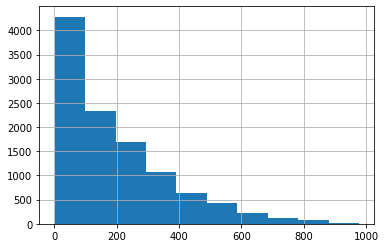

In [42]:
Y.hist()

<AxesSubplot:>

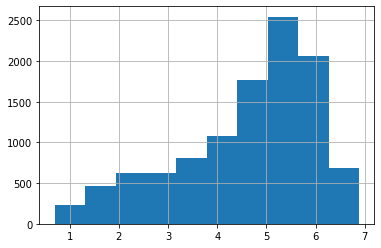

In [43]:
np.log1p(Y).hist()

In [44]:
Y = np.log1p(Y)

In [45]:
model = XGBRegressor()
X_train, X_test, y_train, y_test = train_test_split(data, Y, test_size=0.3, random_state=1993)

In [46]:
model.fit(X_train, y_train)
pred = model.predict(X_test)

In [47]:
rmsle(np.expm1(y_test), np.expm1(pred))

0.31315484924406395

## Simple Submit

In [48]:
from sklearn.model_selection import GridSearchCV

In [49]:
def data_preprocessing(input_data):
    input_data.datetime = input_data.datetime.apply(pd.to_datetime)
    input_data['year'] = input_data.datetime.apply(lambda x : str(x.year))
    input_data['month'] = input_data.datetime.apply(lambda x : str(x.month))
    input_data['time'] = input_data.datetime.apply(lambda x: str(x.hour))
    input_data['weekday'] = input_data.datetime.apply(lambda x: str(x.weekday()))
    
    del input_data['datetime']
    
    input_data.holiday = input_data.holiday.apply(lambda x: str(x))
    input_data.workingday = input_data.workingday.apply(lambda x: str(x))
    input_data.weather = input_data.weather.apply(lambda x: str(x))
    input_data.season = input_data.season.apply(lambda x: str(x))
    return pd.get_dummies(input_data,)

In [50]:
submission = pd.read_csv('./data/sampleSubmission.csv')
test = pd.read_csv('./data/test.csv')
test = data_preprocessing(test)

In [51]:
xgb = XGBRegressor()
model.fit(data, Y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [52]:
columns = data.columns

In [53]:
dummy = pd.DataFrame(columns=columns)
test = pd.concat([dummy, test])

In [54]:
for col in test.columns:
    if test[col].dtype == 'O':
        test[col] = test[col].apply(lambda x: np.uint8(x))

In [55]:
predict = np.expm1(model.predict(test))

In [56]:
submission['count'] = predict

In [57]:
submission.to_csv('./submit/20220721_first_submit.csv', encoding='utf-8', index=False)

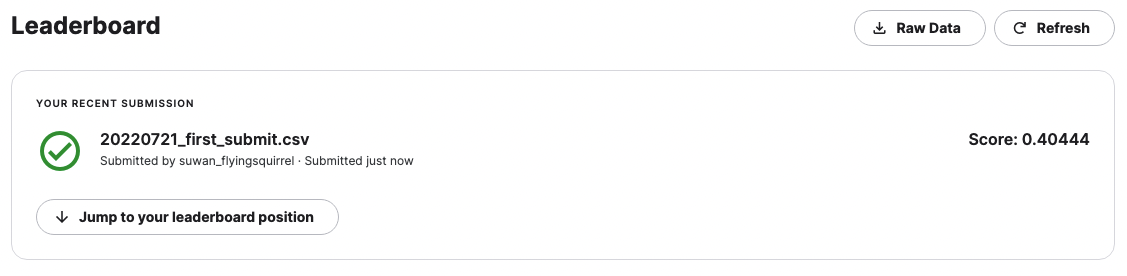